# Figure 4

# Environment

In [1]:
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

%run 00_data_preprocessing.ipynb

dir_path = "results/figures/section4/"
os.makedirs(dir_path, exist_ok=True)

In [2]:
def set_scientific_yticks(ax):
    """Force y-axis to show scientific notation in 10^x format"""
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

def set_scientific_xticks(ay):
    """Force y-axis to show scientific notation in 10^x format"""
    ay.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ay.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

# Model definition

In [3]:
def tst_pulse(t, dose_list, dose_days, delta_t):
    """Return the TST input function F(t), based on dose schedule and delivery window."""
    total = 0
    for dose, day in zip(dose_list, dose_days):
        if day + t_start <= t < day + t_start + delta_t:
            total += dose / delta_t
    return total

def model(y, t, dose_list, dose_days, delta_t, params):
    k_s, e_p, d_e, d_d, d_s, d_m, m_f, k_m = params
    V, E, D, S, M = y
    F_t = tst_pulse(t, dose_list, dose_days, delta_t)

    # ===ODE Model===
    dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    dEdt = F_t + e_p * E * V**2 / (V**2 + k_v)  - d_m * E * M /(k_m+M) - d_e * E
    dDdt = d_m * E * M /(k_m+M) + d_e * E - d_d * D
    dSdt = E - d_s * S
    dMdt = m_f * F_t + m_v * V - m_d * M

    return [dVdt, dEdt, dDdt, dSdt, dMdt]

In [4]:
# ==Fixed param ==
v_r = 9.75e-2
v_k = 1.97e+10
m_v = 3.00e-2
m_d = 0.35

# Other article param
k_v = 2.02e7

t_start = 2 
delta_t = 1

# Optimized param
param = np.array([
    1.2699e-07, 1.5558e+00, 8.9530e-01, 4.9183e-01,
    7.6388e-01, 1.6922e+00, 3.9186e+00, 4.4873e+06
])

# Threshold

In [5]:
# === Define threshold tumor volume from untreated dynamics ===
t_eval = np.arange(-1, 20.01, 0.01)
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]

reference_time = t_start + delta_t  # 2 + 1 = 3 days
sol_base = odeint(model, y0, t_eval, args=([0], [0], delta_t, param))
# Threshold tumor volume: V_ref = tumor volume at Day 3 under untreated condition
V_ref = np.interp(reference_time, t_eval, sol_base[:, 0])

In [6]:
V_ref

215487632.47193494

# Day14 (2week) Fractionated simulation of minimum TST

In [7]:
# === Search for minimal daily dose D* for Day 0–14 daily dosing ===
def find_D_star(dose_days, V_target, target_day, max_dose=1e8, t_eval = np.arange(-1, 20.01, 0.01)):
    for D in np.arange(1e6, max_dose+1e6, 1e5):
        dose_list = [D]*len(dose_days)
        sol = odeint(
            model, y0, t_eval,
            args=(dose_list, dose_days, delta_t, param),
            hmax=0.01
        )

        V_end = np.interp(target_day, t_eval, sol[:, 0])
        
        if V_end <= V_target:
            return D, V_end
            
    return None, None

In [8]:
list(range(0, 15)) # Day 0~Day 14

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [9]:
target_day = 14  # end of treatment period
days_14 = list(range(0, 15))  # Day 0–14 (15 days)
D_star_14, V14_at_Dstar = find_D_star(days_14, V_ref, target_day)
total_tst_14 = D_star_14 * len(days_14)  # total TST used during 15 days

In [10]:
D_star_14

2500000.0

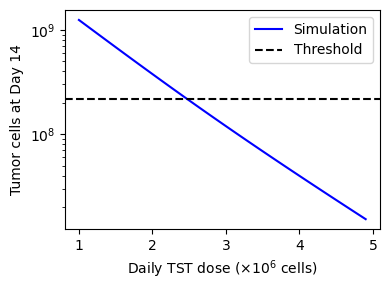

In [11]:
Dstar_range = np.arange(1e6, 5.0e6, 1e5)
V_end_list_14 = []

for D_star in Dstar_range:
    dose_14 = [D_star]*len(days_14) # days_14 = list(range(0, 15)) 
    sol_14 = odeint(
        model, y0, t_eval,
        args = (dose_14, days_14, delta_t, param),
        hmax = 0.01
    )
    # Tumor volume at Day 14
    V_end_14 = np.interp(target_day, t_eval, sol_14[:, 0])  # target_day = 14
    V_end_list_14.append(V_end_14)


plt.figure(figsize=(4, 3))
plt.plot(Dstar_range/1e6, V_end_list_14, label="Simulation", color='blue') # 15-day split
plt.axhline(V_ref, linestyle="--", color="black", label="Threshold")
plt.xlabel(r"Daily TST dose ($\times 10^6$ cells)")
plt.ylabel("Tumor cells at Day 14")
#plt.title("Dose-response curve")
plt.legend()
plt.yscale('log')
#plt.grid(True)
#ax = plt.gca()
#set_scientific_yticks(ax)
#set_scientific_xticks(ax)
plt.tight_layout()
plt.savefig(os.path.join(dir_path, "figSa_minTST.pdf"), dpi=1200, bbox_inches='tight')

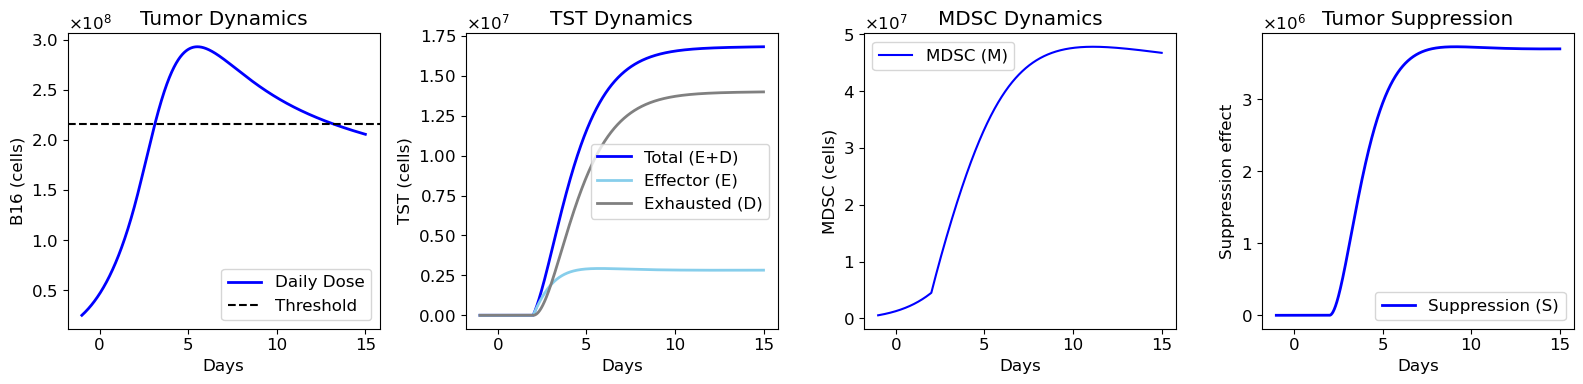

In [12]:
# === Initial Conditions and Time Axis ===
# V: tumor volume, E: effector TSTs, D: exhausted TSTs, S: suppression effect
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]  # y = [V, E, D, S, M]
# Time axis for simulation
t_eval = np.arange(-1, 15.01, 0.01)

# === Daily dosing with D* (15 days from Day 0 to Day 14) ===
dose_list = [D_star_14] * 15    # same daily dose D* each day
dose_days = list(range(0, 15))  # daily administration for 15 days (Day 0–14)
delta_t = 1                     # duration of administration (in days)
sol = odeint(
    model, y0, t_eval, 
    args=(dose_list, dose_days, delta_t, param), 
    hmax=0.01
)
V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
T_sol = E_sol + D_sol

# === Plotting ===
plt.figure(figsize=(16, 4))
plt.rcParams["font.size"] = 12

# --- Panel A: Tumor volume ---
plt.subplot(1, 4, 1)
plt.plot(t_eval, V_sol, label='Daily Dose', color='blue', linewidth=2)
plt.axhline(V_ref, color='black', linestyle='--', label='Threshold')
plt.xlabel("Days")
plt.ylabel("B16 (cells)")
plt.title("Tumor Dynamics")
plt.legend()
ax = plt.gca()
set_scientific_yticks(ax)

# --- Panel B: TST dynamics ---
plt.subplot(1, 4, 2)
plt.plot(t_eval, T_sol, label='Total (E+D)', color='blue', linewidth=2)
plt.plot(t_eval, E_sol, label='Effector (E)', color='skyblue', linewidth=2)
plt.plot(t_eval, D_sol, label='Exhausted (D)', color='gray', linewidth=2)
plt.xlabel('Days')
plt.ylabel('TST (cells)')
plt.title('TST Dynamics')
plt.legend()
ax = plt.gca()
set_scientific_yticks(ax)

# --- Panel C: MDSC ---
plt.subplot(1, 4, 3)
plt.plot(t_eval, M_sol, label='MDSC (M)', color='blue')
plt.xlabel('Days')
plt.ylabel("MDSC (cells)")
plt.title("MDSC Dynamics")
plt.legend()
ax = plt.gca()
set_scientific_yticks(ax)

# --- Panel C: Suppression Effect ---
plt.subplot(1, 4, 4)
plt.plot(t_eval, S_sol, label='Suppression (S)', color='blue', linewidth=2)
plt.xlabel('Days')
plt.ylabel('Suppression effect')
plt.title('Tumor Suppression')
plt.legend()

plt.tight_layout()
ax = plt.gca()
set_scientific_yticks(ax)
plt.savefig(os.path.join(dir_path, "figSb_minTST_sim.pdf"), dpi=1200, bbox_inches='tight')

# Fractionated Simulation

## Function

In [13]:
# TST pulse function
def tst_pulse_strategy(t, schedule, delta_t, t_start=2):
    total = 0
    for dose, day in schedule:
        if day + t_start <= t < day + t_start + delta_t:
            total += dose / delta_t
    return total

# ODE with arbitrary schedule
def ode_with_schedule(y, t, schedule, delta_t, params):
    k_s, e_p, d_e, d_d, d_s, d_m, m_f, k_m = params
    V, E, D, S, M = y
    F_t = tst_pulse_strategy(t, schedule, delta_t, t_start=t_start)
    # ===ODE Model===
    dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    dEdt = F_t + e_p * E * V**2 / (V**2 + k_v) - d_m * E * M /(k_m+M) - d_e * E
    dDdt = d_m * E * M /(k_m+M) + d_e * E - d_d * D
    dSdt = E - d_s * S
    dMdt = m_f * F_t + m_v * V - m_d * M

    return [dVdt, dEdt, dDdt, dSdt, dMdt]

## Scheduling function

In [14]:
# === Schedule generator for Daily / Adaptive / OnOff ===
def generate_schedule(strategy, maxD, D_list, days, t_eval_sched, y0, params):
    """
    Generate a dosing schedule for a given strategy.

    strategy : "Daily", "Adaptive", or "OnOff"
    maxD    : maximum daily dose (e.g., alpha * D_star_14)
    D_list  : allowed dose levels, e.g. [0, maxD/4, maxD/2, maxD]
    days    : list of treatment days, e.g. range(0, 15) for Day 0–14
    t_eval_sched : time grid used when evaluating V(day) during schedule construction
    y0      : initial condition vector
    params  : model parameters (param)
    """

    schedule = []    # list of (dose, day)
    V_days = []      # tumor volume at each day (before dosing)
    prev_D = maxD    # previous day's dose for Adaptive

    for i, day in enumerate(days):
        # 1) simulate up to current day with past schedule 
        t_tmp = t_eval_sched[t_eval_sched <= day]
        sol_tmp = odeint(
            ode_with_schedule, y0, t_tmp,
            args=(schedule, delta_t, params),
            hmax=0.01
        )
        V_today = sol_tmp[-1, 0]   # tumor volume at t = day (before today's dose)
        V_days.append(V_today)

        # 2) decide today's dose based on strategy and tumor change
        if strategy == "Daily":
            D_t = maxD

        elif strategy == "Adaptive":
            if i == 0: # For Day 0, no previous tumor to compare; use maxD
                D_t = maxD
            else:
                V_yesterday = V_days[i - 1]  # tumor volume at Day (day - 1)

                # Tumor increased compared to yesterday
                if V_today > V_yesterday:
                    if prev_D == 0:
                        # Recover from zero: at least smallest non-zero level
                        D_t = D_list[1]  # e.g. maxD/4
                    else:
                        D_t = min(2.0 * prev_D, maxD)

                # Tumor decreased or stayed the same
                else:
                    if prev_D <= D_list[1]:
                        # If previous dose was already the smallest non-zero level, decrease to zero.
                        D_t = 0.0
                    else:
                        D_t = max(prev_D / 2.0, 0.0)
        
        elif strategy == "OnOff":
            if i == 0:
                # For Day 0, give maxD
                D_t = maxD
            else:
                V_yesterday = V_days[i - 1]
                # Give maxD only when tumor increased, otherwise 0
                D_t = maxD if V_today > V_yesterday else 0.0

        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        # 3) append today's dose to schedule and update prev_D
        schedule.append((D_t, day))
        prev_D = D_t

    return schedule, V_days

## Comparison Function

In [15]:
def simulate_with_schedule(schedule, t_all, y0, params, delta_t, target_days=(14.0, 21.0)):
    """
    Simulate tumor-immune dynamics under a given TST dosing schedule.

    Parameters
    ----------
    schedule : list of (dose, day)
        Dosing schedule, e.g. [(D0, 0), (D1, 1), ...].
    t_all : 1D array
        Time grid for the full simulation (e.g. from -1 to 21 days).
    y0 : list or array
        Initial condition [V, E, D, S, M].
    params : list or array
        Model parameters.
    delta_t : float
        Duration (in days) over which each daily dose is delivered.
    target_days : tuple of floats
        Time points at which tumor volume should be evaluated
        (e.g. (14.0, 21.0) for Day 14 and Day 21).

    Returns
    -------
    results : dict
        {
          "t": t_all,
          "sol": sol,
          "V_targets": {day: V(day) for day in target_days},
          "V_series": V(t) over t_all,
          "total_tst": sum of all doses in the schedule
        }
    """
    # Solve ODE system under the given schedule
    sol = odeint(
        ode_with_schedule, y0, t_all,
        args=(schedule, delta_t, params),
        hmax=0.01
    )

    V_series = sol[:, 0]

    # Evaluate tumor volume at target days by interpolation
    V_targets = {}
    for day in target_days:
        V_targets[day] = np.interp(day, t_all, V_series)

    # Total TST administered over the whole period
    total_tst = sum(dose for dose, _ in schedule)

    results = {
        "t": t_all,
        "sol": sol,
        "V_series": V_series,
        "V_targets": V_targets,
        "total_tst": total_tst,
        "schedule": schedule,
    }
    return results

## Overall simulation

In [16]:
np.arange(1.0, 2.01, 0.1) 

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [17]:
# === Settings for alpha-scan and strategy comparison ===

# Treatment days: Day 0–14 (15 days)
days = list(range(0, 15))

# Time grid for constructing schedules (up to Day 14)
t_eval_sched = np.arange(-1.0, 14.01, 0.1)

# Time grid for full simulation (up to Day 21)
t_all = np.arange(-1.0, 21.01, 0.01)

# Range of alpha values to scale D* (e.g., from 0.5 D* to 2.0 D*)
alpha_values = np.arange(1.0, 2.01, 0.1)  # adjust as needed

# Strategies to compare
strategies = ["Daily", "Adaptive", "OnOff", "Single"]

# Dictionary to store results for each strategy
results = {s: [] for s in strategies}

for alpha in alpha_values:
    # Maximum daily dose for this alpha
    maxD = alpha * D_star_14

    # Allowed dose levels for Adaptive/OnOff
    D_list = [0.0, maxD/4.0, maxD/2.0, maxD]

    # --- 1) Daily / Adaptive / OnOff: generate schedules and simulate ---
    for strategy in ["Daily", "Adaptive", "OnOff"]:
        # Generate dosing schedule for the given strategy
        schedule, V_days = generate_schedule(
            strategy=strategy,
            maxD=maxD,
            D_list=D_list,
            days=days,
            t_eval_sched=t_eval_sched,
            y0=y0,
            params=param
        )

        # Simulate full dynamics up to Day 21
        sim_res = simulate_with_schedule(
            schedule=schedule,
            t_all=t_all,
            y0=y0,
            params=param,
            delta_t=delta_t,
            target_days=(14.0, 21.0)
        )
        
        sol = sim_res["sol"]
        V14 = sim_res["V_targets"][14.0]
        V21 = sim_res["V_targets"][21.0]
        total_tst = sim_res["total_tst"]

        results[strategy].append({
            "alpha": alpha,
            "maxD": maxD,
            "sol": sol,
            "V14": V14,
            "V21": V21,
            "total_tst": total_tst,
            "schedule": schedule,
            "V_days": V_days,
        })

    # --- 2) Single: total dose = 15 * maxD given at Day 0 ---
    total_single = maxD * len(days)          # same total dose as 15 days of maxD
    schedule_single = [(total_single, 0)]    # single bolus at Day 0

    sim_res_single = simulate_with_schedule(
        schedule=schedule_single,
        t_all=t_all,
        y0=y0,
        params=param,
        delta_t=delta_t,
        target_days=(14.0, 21.0)
    )
    sol_single = sim_res_single["sol"]
    V14_single = sim_res_single["V_targets"][14.0]
    V21_single = sim_res_single["V_targets"][21.0]

    results["Single"].append({
        "alpha": alpha,
        "maxD": maxD,
        "sol": sol_single,
        "V14": V14_single,
        "V21": V21_single,
        "total_tst": total_single,
        "schedule": schedule_single,
    })


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.9957229599445D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1991445919889D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1991445919889D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.7898420688134D-16
 lsoda--  warning..internal t (=r1) 

# Visualization

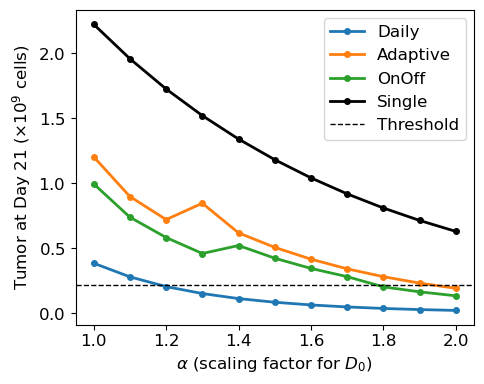

In [18]:
# Strategies to plot
plot_strategies = ["Daily", "Adaptive", "OnOff", "Single"]

# Optional: color map for strategies
strategy_colors = {
    "Daily":   "tab:blue",
    "Adaptive": "tab:orange",
    "OnOff":   "tab:green",
    "Single":  "black",
}

# === Figure 1: alpha vs V(21) for each strategy ===
plt.rcParams["font.size"] = 12

fig1, ax1 = plt.subplots(figsize=(5, 4))

for strategy in plot_strategies:
    data_list = results[strategy]

    # Extract alpha and V21 for this strategy
    alphas = np.array([d["alpha"] for d in data_list])
    V21s   = np.array([d["V21"]   for d in data_list])

    # Sort by alpha just in case
    order = np.argsort(alphas)
    alphas_sorted = alphas[order]
    V21s_sorted   = V21s[order]

    color = strategy_colors.get(strategy, None)

    ax1.plot(
        alphas_sorted, V21s_sorted/1e9,
        label=strategy,
        marker="o",
        markersize=4,
        linewidth=2,
        color=color,
    )

ax1.set_xlabel(r"$\alpha$ (scaling factor for $D_0$)")
ax1.set_ylabel(r"Tumor at Day 21 ($\times 10^9$ cells)")
set_scientific_yticks(ax1)
ax1.axhline(y=V_ref/1e9, color='black', linestyle='--', linewidth=1, label='Threshold')
#ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)
#ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
fig1.tight_layout()
fig1.savefig(os.path.join(dir_path, "fig4a.pdf"), dpi=1200, bbox_inches='tight')

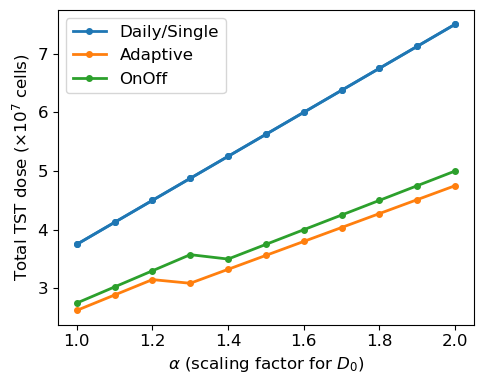

In [19]:
# === Figure 2: alpha vs total TST dose for each strategy ===
# Optional: color map for strategies
strategy_colors_temp = {
    "Daily":   "tab:blue",
    "Adaptive": "tab:orange",
    "OnOff":   "tab:green",
    "Single":  "tab:blue",
}

fig2, ax2 = plt.subplots(figsize=(5, 4))

for strategy in plot_strategies:
    data_list = results[strategy]

    # Extract alpha and total_tst
    alphas = np.array([d["alpha"] for d in data_list])
    totals = np.array([d["total_tst"] for d in data_list])  # absolute number of cells

    order = np.argsort(alphas)
    alphas_sorted = alphas[order]
    totals_sorted = totals[order]

    color = strategy_colors_temp.get(strategy, None)

    # --- Combine "Daily" and "Single" label ---
    if strategy in ["Daily", "Single"]:
        label = "Daily/Single"
    else:
        label = strategy

    # Convert total TST to 10^7 units for readability
    ax2.plot(
        alphas_sorted,
        totals_sorted / 1e7,
        label=label,
        marker="o",
        markersize=4,
        linewidth=2,
        color=color,
    )

ax2.set_xlabel(r"$\alpha$ (scaling factor for $D_0$)")
ax2.set_ylabel(r"Total TST dose ($\times 10^7$ cells)")

handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) 
ax2.legend(by_label.values(), by_label.keys())

fig2.tight_layout()
fig2.savefig(os.path.join(dir_path, "fig4b.pdf"), dpi=1200, bbox_inches="tight")


# Specific alpha example

## Function

In [20]:
def get_result_at_alpha(results_list, alpha_target, atol=1e-8):
    """Return the first result dict with alpha close to alpha_target."""
    for res in results_list:
        if np.isclose(res["alpha"], alpha_target, atol=atol):
            return res
    return None

In [21]:
def collect_results_for_alpha(results, alpha_target, strategies=None, atol=1e-8):
    """Extract results at a given alpha for multiple strategies."""
    if strategies is None:
        strategies = list(results.keys())
    results_alpha = {}
    for strategy in strategies:
        res = get_result_at_alpha(results[strategy], alpha_target, atol=atol)
        if res is None:
            raise ValueError(f"No result found for {strategy} at alpha={alpha_target}")
        results_alpha[strategy] = res
    return results_alpha

In [22]:
def plot_tumor_compare_all_strategies(results, alpha_target, dir_path, 
                                      filename="fig_tumor_compare_all_alpha{alpha:.2f}.pdf",):
    """
    Plot tumor trajectories for Single, Daily, Adaptive, and OnOff
    at a given alpha on a single axis (no dose bars).

    Parameters
    ----------
    results : dict
        Simulation results for all alphas and strategies.
    alpha_target : float
        Target alpha to visualize.
    dir_path : str
        Directory to save the figure.
    filename : str
        Output filename template (may contain {alpha}).
    """
    strategies = ["Single", "Daily", "Adaptive", "OnOff"]
    results_alpha = collect_results_for_alpha(results, alpha_target, strategies=strategies)
    
    plt.rcParams["font.size"] = 12
    fig, ax = plt.subplots(figsize=(4, 3))

    for strategy in strategies:
        sol = results_alpha[strategy]["sol"]
        V_sol = sol[:, 0]

        color = strategy_colors.get(strategy, None)

        ax.plot(t_all, V_sol, label=strategy,
                linewidth=2, color=color)

    ax.axhline(V_ref, color="black", linestyle="--", linewidth=1.5, label="Threshold")

    ax.set_xlabel("Days")
    ax.set_ylabel("B16 (cells)")
    set_scientific_yticks(ax)
    
    ax.legend(fontsize=11)

    fig.tight_layout()
    out_name = filename.format(alpha=alpha_target)
    out_path = os.path.join(dir_path, out_name)
    fig.savefig(out_path, dpi=1200, bbox_inches="tight")

In [23]:
def plot_tumor_vs_single_panels(results, alpha_target, dir_path,
                                filename="fig_tumor_vs_single_alpha{alpha:.2f}.pdf"):
    """
    Plot tumor trajectories for Daily/Adaptive/OnOff at given alpha,
    overlaid with Single, plus dose bars. Save to dir_path.

    Parameters
    ----------
    results : dict
        Simulation results for all alphas and strategies.
    alpha_target : float
        Target alpha to visualize.
    dir_path : str
        Directory to save the figure.
    filename : str
        Output filename template (may contain {alpha}).
    """
    
    # Collect results at this alpha
    results_alpha = collect_results_for_alpha(
        results, alpha_target,
        strategies=["Daily", "Adaptive", "OnOff", "Single"]
    )

    # Single trajectory (common overlay)
    sol_single = results_alpha["Single"]["sol"]
    V_sol_single = sol_single[:, 0]

    panel_strategies = ["Daily", "Adaptive", "OnOff"]

    fig = plt.figure(figsize=(25, 5), dpi=200)
    plt.rcParams["font.size"] = 18
    gs = gridspec.GridSpec(1, len(panel_strategies), hspace=0.5, wspace=0.3)

    for idx, strategy in enumerate(panel_strategies):
        data = results_alpha[strategy]
        sol = data["sol"]
        schedule = data["schedule"]

        V_sol = sol[:, 0]

        # Build dose time-series for plotting (no t_start shift)
        doses_plot = np.zeros_like(t_all)
        for dose, day in schedule:
            mask = (t_all >= day) & (t_all < day + 0.4)  # 0.4-day-wide bar
            doses_plot[mask] = dose

        ax0 = fig.add_subplot(gs[0, idx])

        # Tumor trajectories
        ax0.plot(t_all, V_sol, label=f"{strategy}", linewidth=3, color="tab:red")
        ax0.plot(t_all, V_sol_single, label="Single", linewidth=3, color="black")
        ax0.axhline(V_ref, color="black", linestyle="--", label="Threshold")

        ax0.set_xlabel("Days")
        ax0.set_ylabel("B16 (cells)", color="black")
        ax0.tick_params(axis="y", labelcolor="black")
        set_scientific_yticks(ax0)
        ax0.set_title(f"{strategy} (alpha={alpha_target:g})")

        # Secondary axis: TST doses
        ax0b = ax0.twinx()
        ax0b.bar(t_all, doses_plot / 1e6, width=0.1,
                 color="blue", alpha=0.04, label="Injected TST")
        ax0b.set_ylabel("TST Dose (×10⁶ cells)", color="blue")
        ax0b.tick_params(axis="y", labelcolor="blue")
        ax0b.set_ylim([0, max(doses_plot / 1e6) * 1.5 if doses_plot.max() > 0 else 1.0])
        set_scientific_yticks(ax0b)

        ax0.legend(loc="upper left")
        ax0b.legend(loc="upper right")

    plt.subplots_adjust(left=0.05, right=0.98, top=0.93, bottom=0.07,
                        wspace=0.3, hspace=0.5)

    out_name = filename.format(alpha=alpha_target)
    out_path = os.path.join(dir_path, out_name)
    plt.savefig(out_path, dpi=1200, bbox_inches="tight")
    # plt.close(fig)

In [24]:
def plot_total_tst_bar(results, alpha_target, dir_path,
                       filename="fig_total_TST_alpha{alpha:.2f}.pdf"):
    """
    Plot total TST dose for each strategy at given alpha, with Daily/Single merged.

    Parameters
    ----------
    results : dict
        Simulation results for all alphas and strategies.
    alpha_target : float
        Target alpha to visualize.
    dir_path : str
        Directory to save the figure.
    filename : str
        Output filename template (may contain {alpha}).
    """
    plt.rcParams["font.size"] = 12

    results_alpha = collect_results_for_alpha(
        results, alpha_target,
        strategies=["Daily", "Adaptive", "OnOff", "Single"]
    )

    daily_total    = results_alpha["Daily"]["total_tst"]
    adaptive_total = results_alpha["Adaptive"]["total_tst"]
    onoff_total    = results_alpha["OnOff"]["total_tst"]
    single_total   = results_alpha["Single"]["total_tst"]

    # Sanity check
    if not np.isclose(daily_total, single_total):
        print("[Warning] Daily and Single total doses are not identical:",
              daily_total, single_total)

    plot_strategies = ["Daily/Single", "Adaptive", "OnOff"]
    total_doses_plot = [
        daily_total / 1e7,      # Daily/Single
        adaptive_total / 1e7,   # Adaptive
        onoff_total / 1e7,      # OnOff
    ]

    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    ax.bar(plot_strategies, total_doses_plot, color="cornflowerblue")
    ax.set_xlabel("Strategy")
    ax.set_ylabel(r"Total TST Dose ($\times 10^7$ cells)")
    ax.grid(axis="y")

    fig.tight_layout()
    out_name = filename.format(alpha=alpha_target)
    out_path = os.path.join(dir_path, out_name)
    plt.savefig(out_path, dpi=1200, bbox_inches="tight")
    # plt.close(fig)

In [25]:
def plot_full_dynamics_panels(results, alpha_target, dir_path,
                              filename="fig_full_dynamics_alpha{alpha:.2f}.pdf"):
    """
    Plot full dynamics (tumor, T cells, suppression S, MDSC) for each
    dynamic strategy at given alpha, with Single overlaid only in the tumor panel.

    Parameters
    ----------
    results : dict
        Simulation results for all alphas and strategies.
    alpha_target : float
        Target alpha to visualize.
    dir_path : str
        Directory to save the figure.
    filename : str
        Output filename template (may contain {alpha}).
    """
    plt.rcParams["font.size"] = 14

    # Get results at this alpha
    results_alpha = collect_results_for_alpha(
        results, alpha_target,
        strategies=["Daily", "Adaptive", "OnOff", "Single"]
    )

    # Single trajectory
    sol_single = results_alpha["Single"]["sol"]
    V_sol_single = sol_single[:, 0]

    plot_strategies = ["Daily", "Adaptive", "OnOff"]

    fig = plt.figure(figsize=(25, 15))
    gs = gridspec.GridSpec(len(plot_strategies), 4, hspace=0.5, wspace=0.3)

    for idx, strategy in enumerate(plot_strategies):
        data = results_alpha[strategy]
        sol = data["sol"]
        schedule = data["schedule"]

        V_sol = sol[:, 0]
        E_sol = sol[:, 1]
        D_sol = sol[:, 2]
        S_sol = sol[:, 3]
        M_sol = sol[:, 4]
        T_sol = E_sol + D_sol

        # Dose time-series
        doses_plot = np.zeros_like(t_all)
        for dose, day in schedule:
            mask = (t_all >= day) & (t_all < day + 0.4)
            doses_plot[mask] = dose

        # Col 0: tumor + Single + dose
        ax0 = fig.add_subplot(gs[idx, 0])
        ax0.plot(t_all, V_sol, label=f"{strategy}", linewidth=3, color="tab:red")
        ax0.plot(t_all, V_sol_single, label="Single", linewidth=3, color="black")
        ax0.axhline(V_ref, color="black", linestyle="--", label="Threshold")
        ax0.set_xlabel("Days")
        ax0.set_ylabel("B16 (cells)", color="black")
        ax0.tick_params(axis="y", labelcolor="black")
        set_scientific_yticks(ax0)
        ax0.set_title(f"{strategy} - Tumor")

        ax0b = ax0.twinx()
        ax0b.bar(t_all, doses_plot / 1e6, width=0.1,
                 color="blue", alpha=0.04, label="Injected TST")
        ax0b.set_ylabel("TST Dose (×10⁶ cells)", color="blue")
        ax0b.tick_params(axis="y", labelcolor="blue")
        ax0b.set_ylim([0, max(doses_plot / 1e6) * 1.5 if doses_plot.max() > 0 else 1.0])
        set_scientific_yticks(ax0b)

        ax0.legend(loc="upper left")
        ax0b.legend(loc="upper right")

        # Col 1: T cells
        ax1 = fig.add_subplot(gs[idx, 1])
        ax1.plot(t_all, T_sol, label="T (Total)", color="blue")
        ax1.plot(t_all, E_sol, label="E (Effector)", color="skyblue")
        ax1.plot(t_all, D_sol, label="D (Exhausted)", color="gray")
        ax1.set_title(f"{strategy} - TST dynamics")
        ax1.set_xlabel("Days")
        ax1.set_ylabel("TST (cells)")
        ax1.legend()
        set_scientific_yticks(ax1)

        # Col 2: Suppression S
        ax2 = fig.add_subplot(gs[idx, 2])
        ax2.plot(t_all, S_sol, label="S (Suppression)", color="green")
        ax2.set_title(f"{strategy} - Suppression S")
        ax2.set_xlabel("Days")
        ax2.set_ylabel("Suppression")
        ax2.legend()
        set_scientific_yticks(ax2)

        # Col 3: MDSC
        ax3 = fig.add_subplot(gs[idx, 3])
        ax3.plot(t_all, M_sol, label="MDSC", color="red")
        ax3.set_title(f"{strategy} - MDSC")
        ax3.set_xlabel("Days")
        ax3.set_ylabel("MDSC (cells)")
        ax3.legend()
        set_scientific_yticks(ax3)

    plt.subplots_adjust(
        left=0.05, right=0.98, top=0.93, bottom=0.07,
        wspace=0.3, hspace=0.5
    )

    out_name = filename.format(alpha=alpha_target)
    out_path = os.path.join(dir_path, out_name)
    plt.savefig(out_path, dpi=1200, bbox_inches="tight")
    # plt.close(fig)

In [26]:
def compute_V21_reduction_vs_single(results, alpha_target, strategies=None, atol=1e-8):
    """
    Compute percent reduction in tumor cells at Day 21 relative to Single for a given alpha.
    """
    if strategies is None:
        strategies = ["Daily", "Adaptive", "OnOff"]

    # Get results at this alpha including Single
    results_alpha = collect_results_for_alpha(
        results, alpha_target,
        strategies=strategies + ["Single"],
        atol=atol
    )

    V21_single = results_alpha["Single"]["V21"]

    reductions = {}
    for strategy in strategies:
        V21_strat = results_alpha[strategy]["V21"]
        # percent reduction relative to Single
        percent_change = 100.0 * (1.0 - V21_strat / V21_single)
        reductions[strategy] = (V21_strat, percent_change)

    return reductions


# Alpha=1

alpha=1.0, Daily: V21=3.839e+08, 82.7% smaller than Single
alpha=1.0, Adaptive: V21=1.202e+09, 45.9% smaller than Single
alpha=1.0, OnOff: V21=9.940e+08, 55.3% smaller than Single


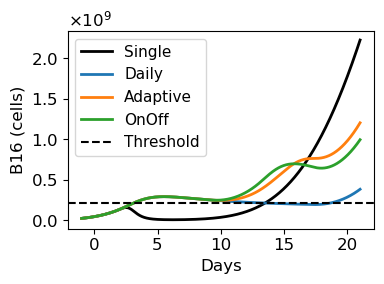

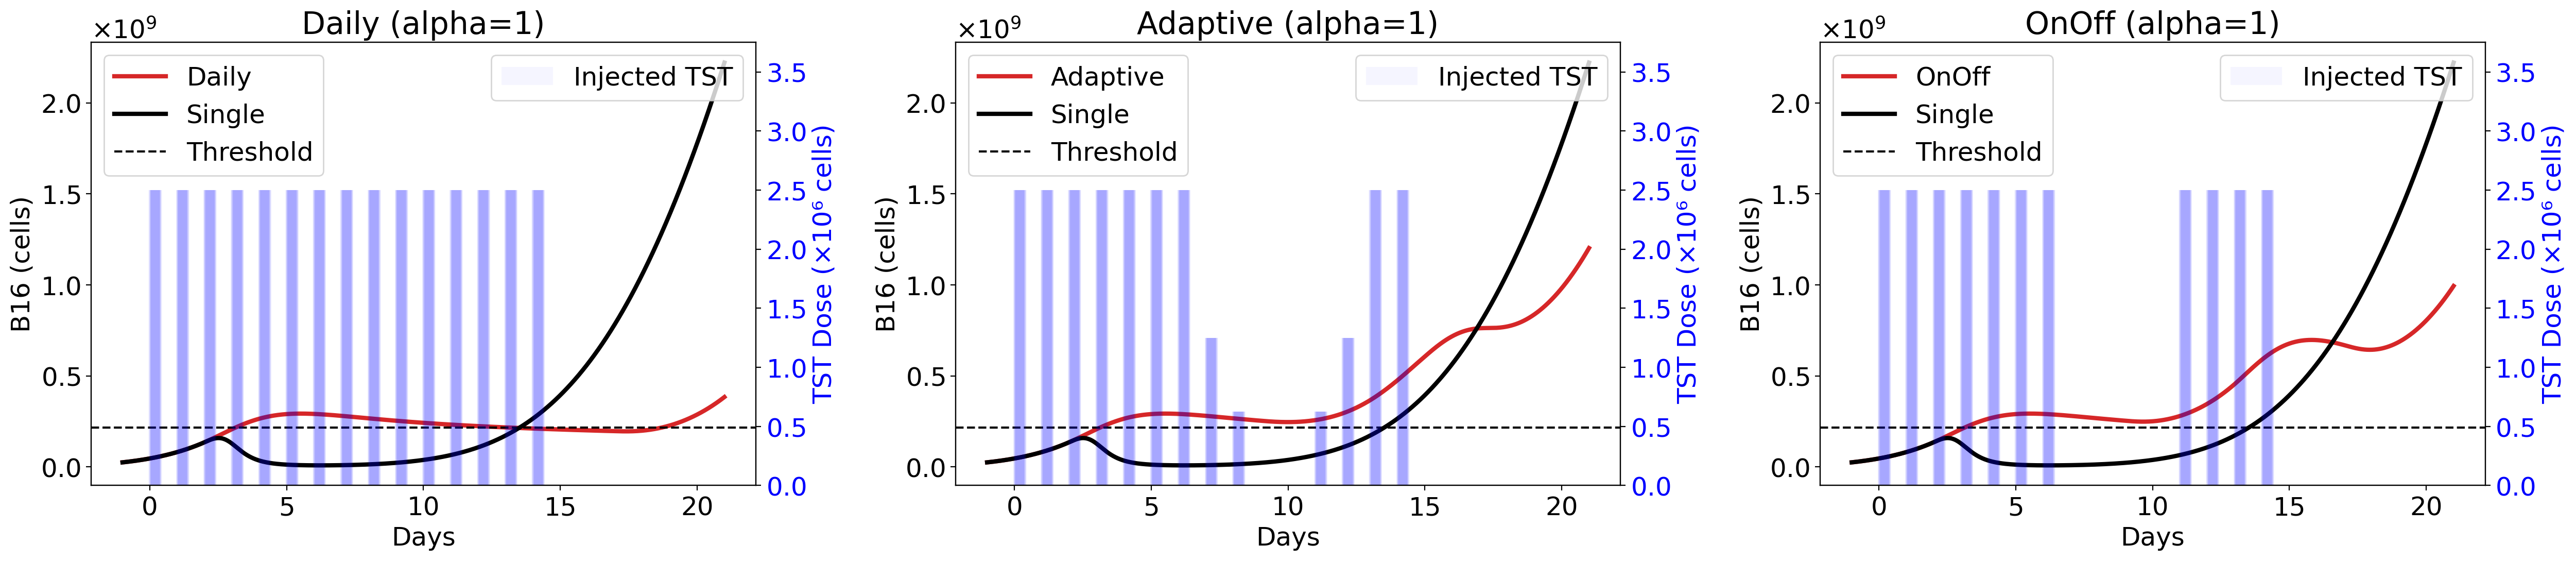

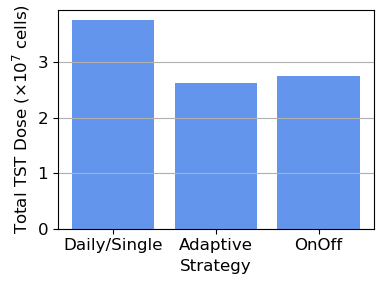

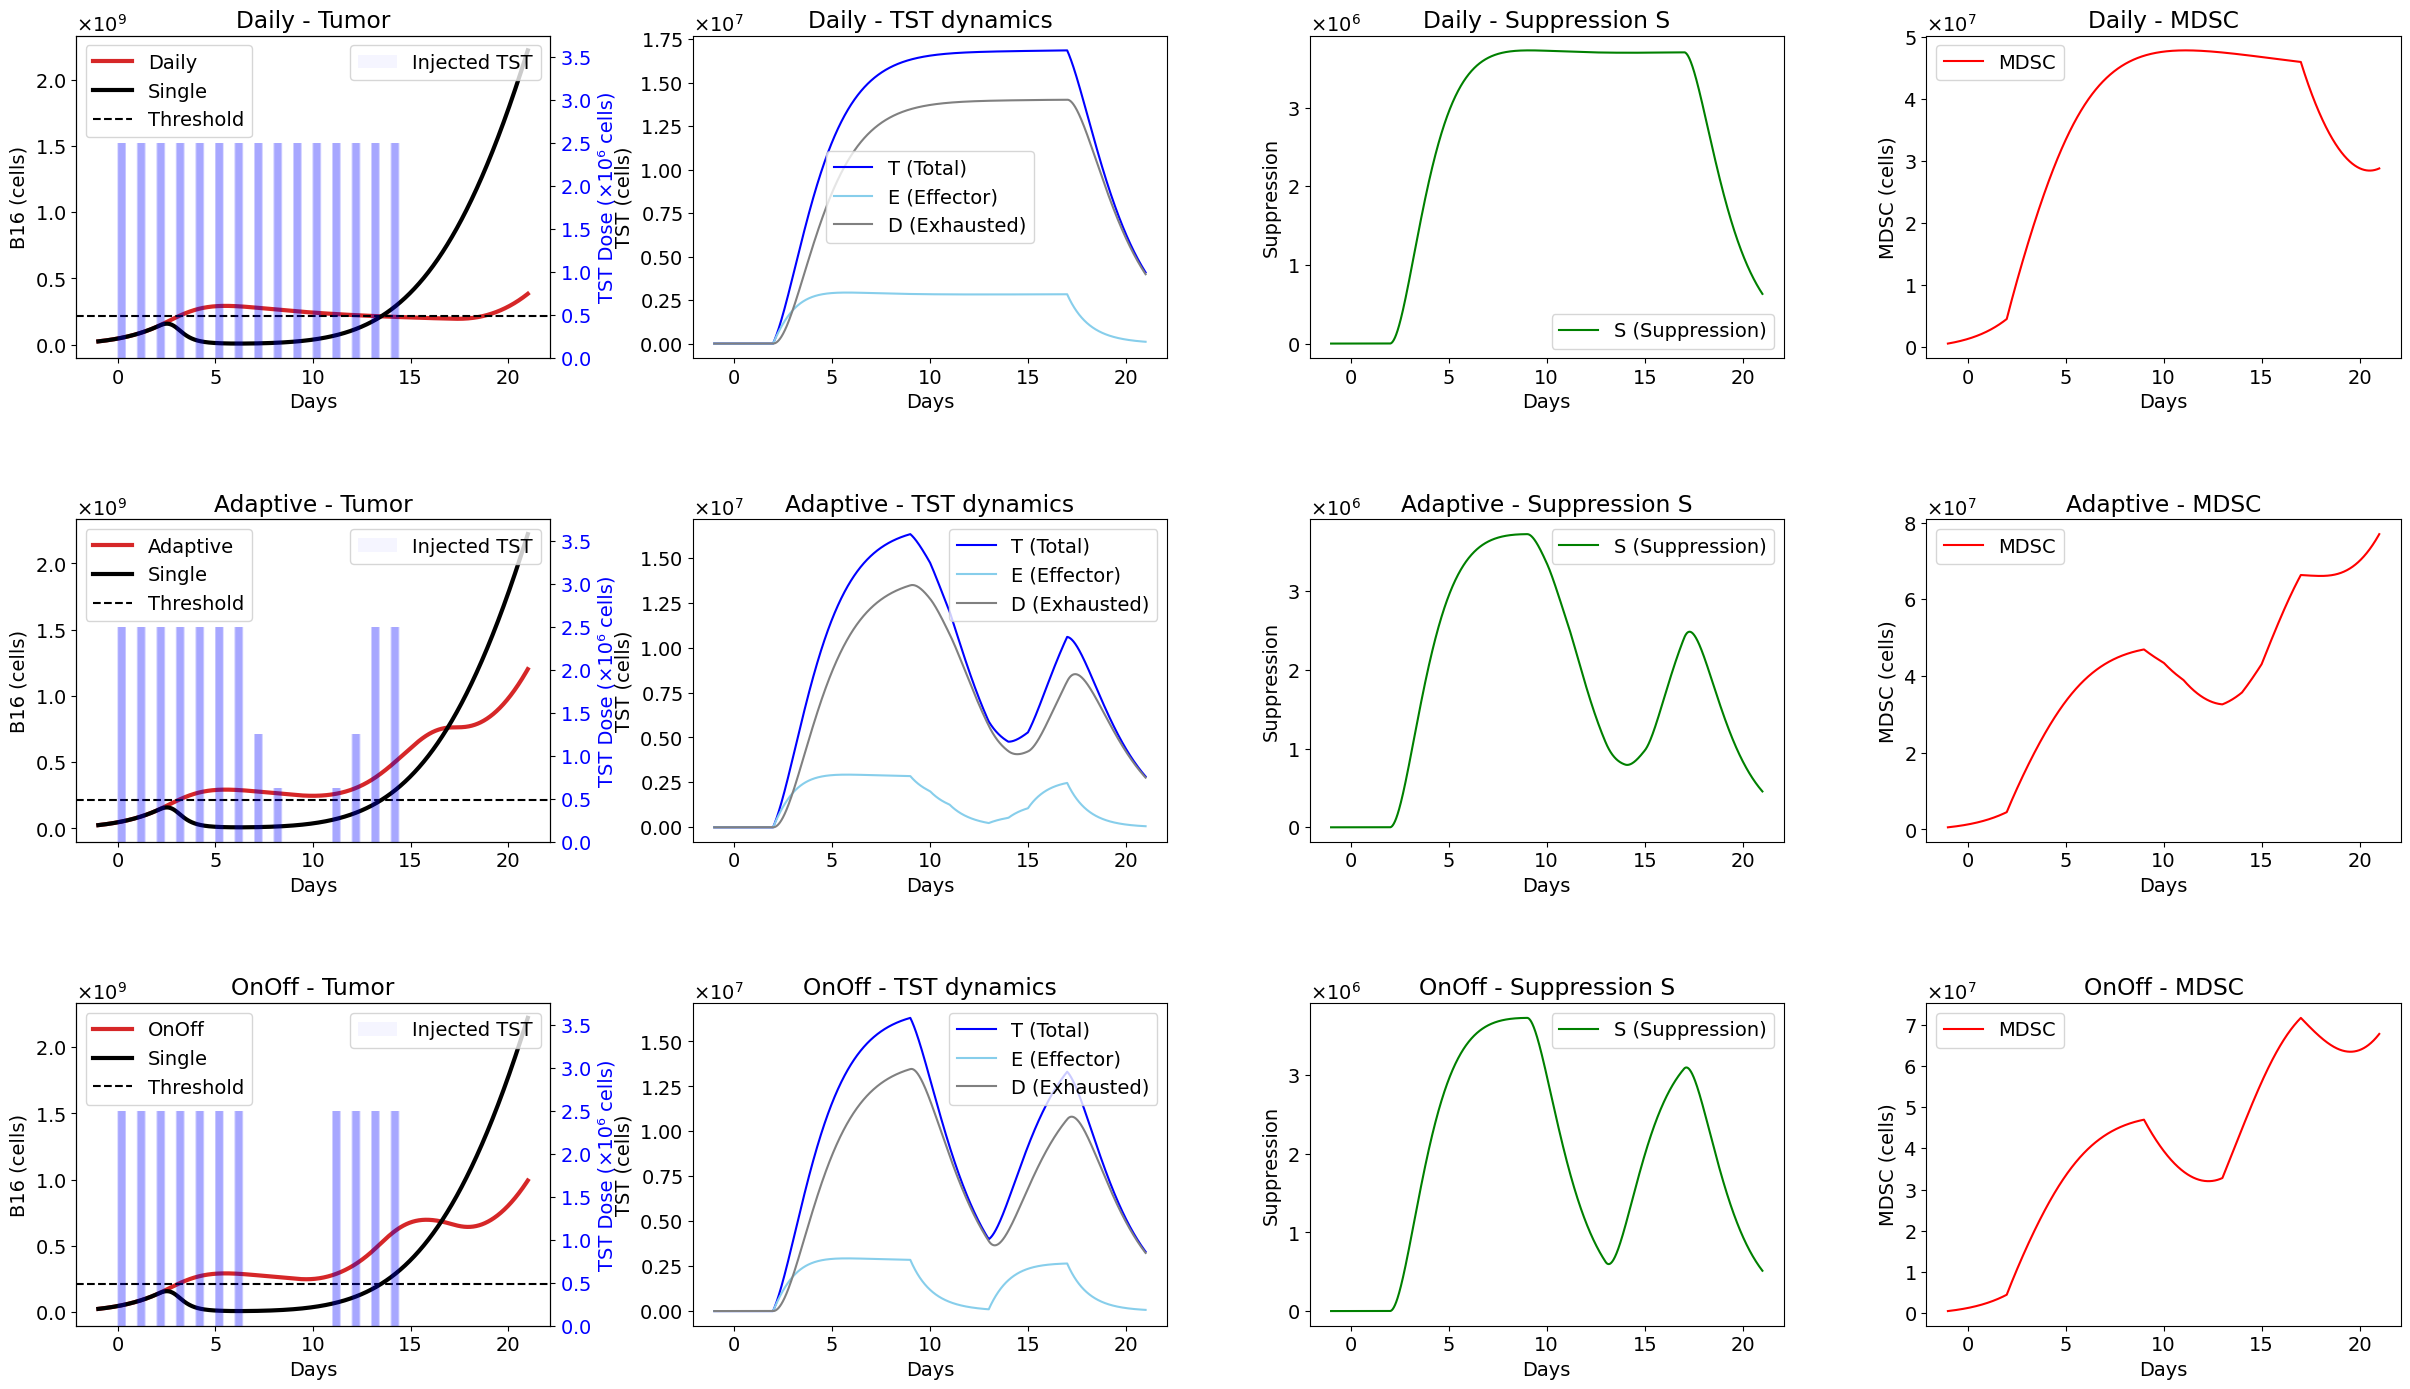

In [27]:
alpha_target = 1.0
plot_tumor_compare_all_strategies(results, alpha_target, dir_path,
                            filename="fig_all_tumor_alpha{alpha:.1f}.pdf")
plot_tumor_vs_single_panels(results, alpha_target, dir_path,
                            filename="fig_tumor_alpha{alpha:.1f}.pdf")
plot_total_tst_bar(results, alpha_target, dir_path,
                   filename="fig_totalTST_alpha{alpha:.1f}.pdf")
plot_full_dynamics_panels(results, alpha_target, dir_path,
                          filename="fig_dynamics_alpha{alpha:.1f}.pdf")

reductions = compute_V21_reduction_vs_single(results, alpha_target)

for strategy, (V21_strat, pct) in reductions.items():
    direction = "smaller" if pct >= 0 else "larger"
    print(f"alpha={alpha_target}, {strategy}: "
          f"V21={V21_strat:.3e}, "
          f"{abs(pct):.1f}% {direction} than Single")

# Alpha=2

alpha=2.0, Daily: V21=2.075e+07, 96.7% smaller than Single
alpha=2.0, Adaptive: V21=1.907e+08, 69.6% smaller than Single
alpha=2.0, OnOff: V21=1.330e+08, 78.8% smaller than Single


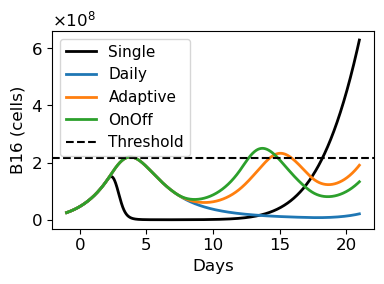

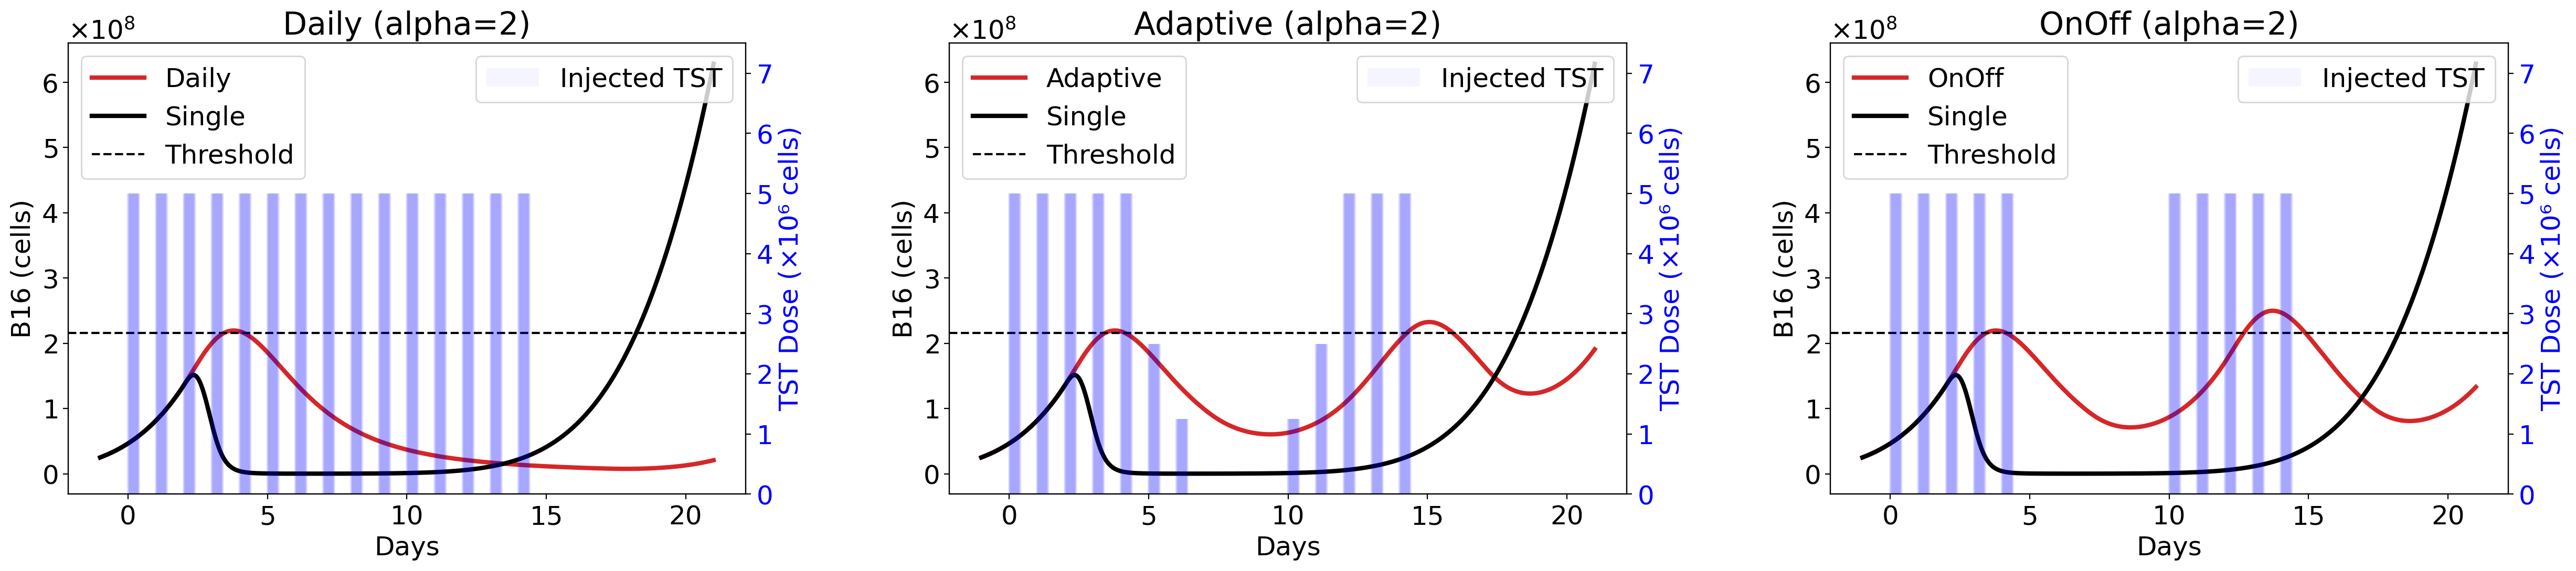

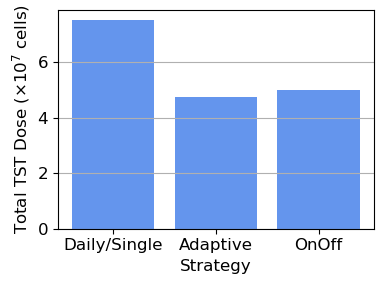

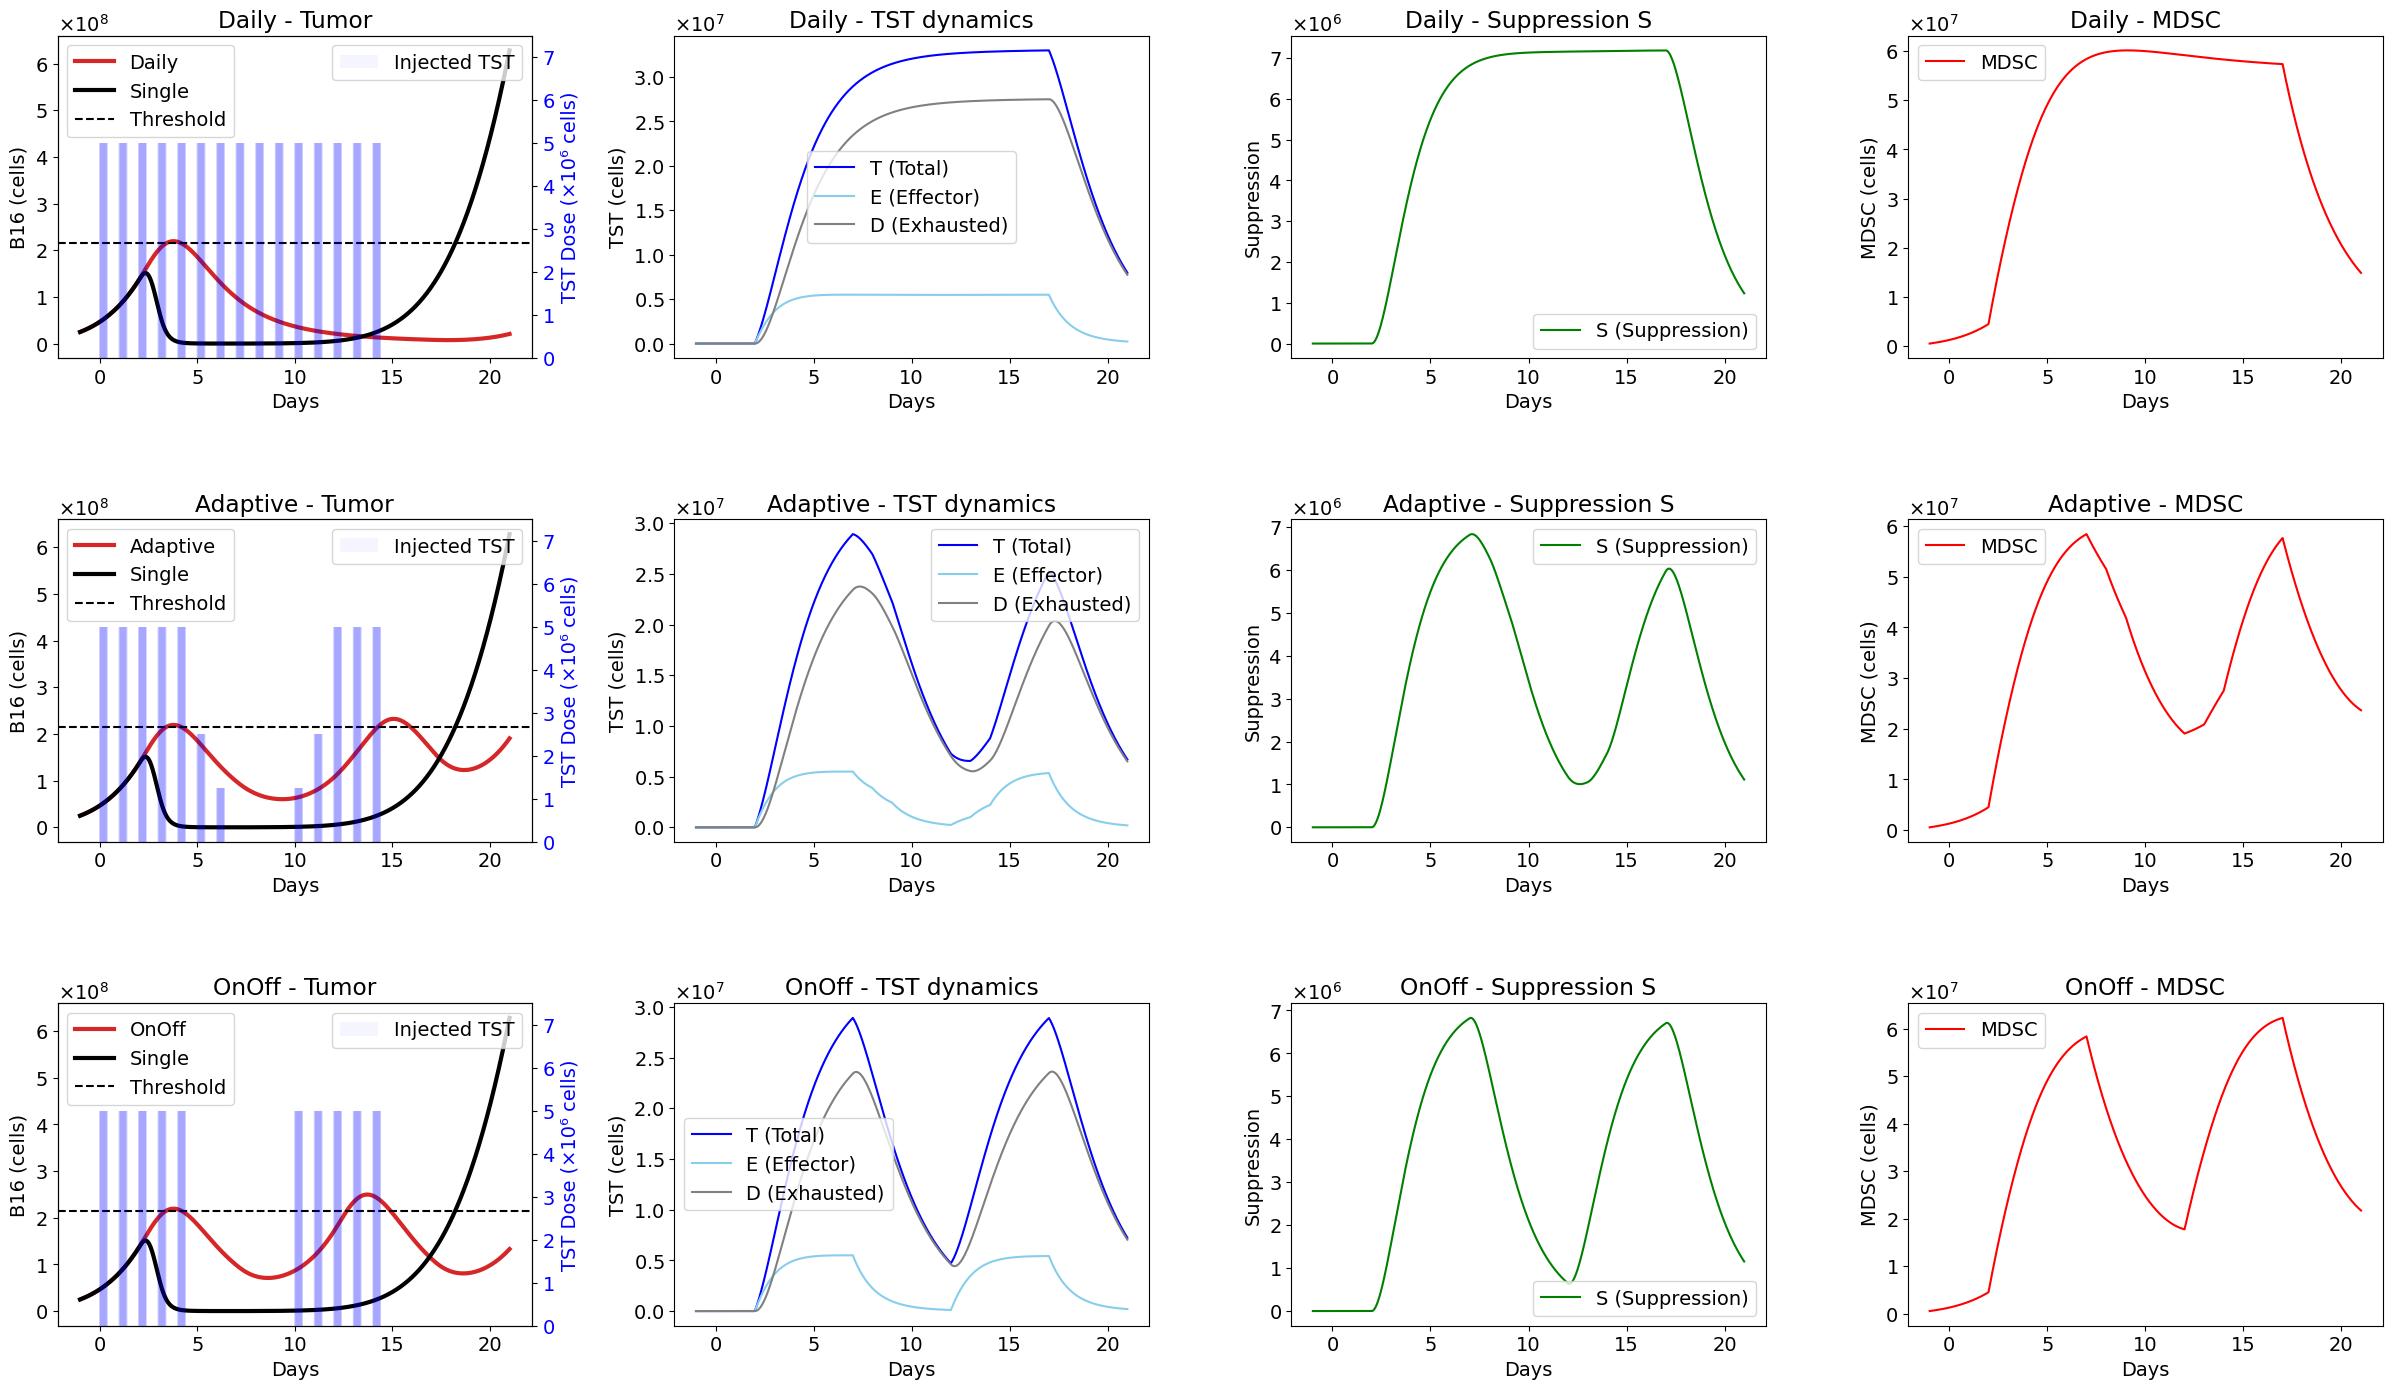

In [28]:
alpha_target = 2.0
plot_tumor_compare_all_strategies(results, alpha_target, dir_path,
                            filename="fig_all_tumor_alpha{alpha:.1f}.pdf")
plot_tumor_vs_single_panels(results, alpha_target, dir_path,
                            filename="fig_tumor_alpha{alpha:.1f}.pdf")
plot_total_tst_bar(results, alpha_target, dir_path,
                   filename="fig_totalTST_alpha{alpha:.1f}.pdf")
plot_full_dynamics_panels(results, alpha_target, dir_path,
                          filename="fig_dynamics_alpha{alpha:.1f}.pdf")

reductions = compute_V21_reduction_vs_single(results, alpha_target)

for strategy, (V21_strat, pct) in reductions.items():
    direction = "smaller" if pct >= 0 else "larger"
    print(f"alpha={alpha_target}, {strategy}: "
          f"V21={V21_strat:.3e}, "
          f"{abs(pct):.1f}% {direction} than Single")

In [29]:
alpha_target_2 = 2
res2 = collect_results_for_alpha(results, alpha_target_2)
strategies = ["Daily", "Adaptive", "OnOff", "Single"]
TST_daily = res2["Daily"]["total_tst"]
TST_adaptive = res2["Adaptive"]["total_tst"]
TST_onoff = res2["OnOff"]["total_tst"]

In [30]:
alpha_target_2 = 2
res2 = collect_results_for_alpha(results, alpha_target_2)
strategies = ["Daily", "Adaptive", "OnOff", "Single"]

# Total TST dose
total_tst = {s: res2[s]["total_tst"] for s in strategies}
TST_single = total_tst["Single"]

# Dose relative to the Single strategy
relative_dose = {s: total_tst[s] / TST_single for s in strategies}

# Percentage reduction compared to the Single strategy
reduction_percent = {
    s: 100.0 * (1.0 - total_tst[s] / TST_single)
    for s in ["Daily", "Adaptive", "OnOff"]  
}

print("Total TST:")
for s in strategies:
    print(f"  {s}: {total_tst[s]:.3e} cells")

print("\nRelative dose (Single = 1):")
for s in strategies:
    print(f"  {s}: {relative_dose[s]:.3f}")

print("\nReduction compared to Single (%):")
for s in ["Daily", "Adaptive", "OnOff"]:
    print(f"  {s}: {reduction_percent[s]:.1f} %")


Total TST:
  Daily: 7.500e+07 cells
  Adaptive: 4.750e+07 cells
  OnOff: 5.000e+07 cells
  Single: 7.500e+07 cells

Relative dose (Single = 1):
  Daily: 1.000
  Adaptive: 0.633
  OnOff: 0.667
  Single: 1.000

Reduction compared to Single (%):
  Daily: 0.0 %
  Adaptive: 36.7 %
  OnOff: 33.3 %
